In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


%config InlineBackend.figure_format = 'png'

In [2]:
train = pd.read_csv("data/london_listings.csv")

In [3]:
columns_to_keep = ["price", "neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "name", "summary",
                   "amenities", "latitude", "longitude", "number_of_reviews",
                   "require_guest_phone_verification", "minimum_nights"]

train = train[columns_to_keep]
train.head()

,price,neighbourhood_cleansed,bedrooms,property_type,room_type,name,summary,amenities,latitude,longitude,number_of_reviews,require_guest_phone_verification,minimum_nights
0,100,Camden,1.0,Apartment,Private room,"Studio-like floral themed bedroom, central London",A floral themed designed bedroom that A flor...,"{Wifi,Kitchen,Elevator,Heating,Washer,Dryer,Es...",51.52957,-0.12074,13,f,1
1,43,Merton,1.0,Apartment,Entire home/apt,Our family home,A cosy private studio flat in a quiet housing ...,"{TV,Wifi,Kitchen,""Free parking on premises"",Br...",51.40677,-0.14920,1,f,3
2,180,Westminster,2.0,Apartment,Entire home/apt,Luxurious top floor flat next to Regent's Park,Beautiful and airy two bedroom flat in St. Joh...,"{TV,Wifi,Kitchen,Elevator,""Indoor fireplace"",H...",51.53356,-0.16586,9,f,3
3,100,Waltham Forest,2.0,Apartment,Entire home/apt,Trendy East London flat with park views,Lovely house in East London Perfect if you wan...,"{TV,Wifi,Kitchen,""Free parking on premises"",""F...",51.56652,-0.03130,3,f,4
4,96,Hammersmith and Fulham,2.0,Apartment,Entire home/apt,Spacious 2 Bedroom Flat in Great Location,"Well lit, spacious, 2 bedroom flat in West Ken...","{Wifi,Kitchen,""Paid parking off premises"",Heat...",51.49747,-0.21248,3,f,4


In [4]:
def clean(train):

    train["bedrooms"] = train["bedrooms"].fillna(0.5) #these are studios
    train["summary"] = train["summary"].fillna("")
    train["bedrooms"] = train["bedrooms"].astype("str")

    #replace unpopular types with other 
    popular_types = train["property_type"].value_counts().head(6).index.values
    train.loc[~train.property_type.isin(popular_types), "property_type"] = "Other"

    #make price numeric:
    train["price"] = train["price"].replace("[$,]", "")
    #eliminate crazy prices:
    train = train[train["price"] < 600]
    
    return train

In [5]:
train = clean(train)

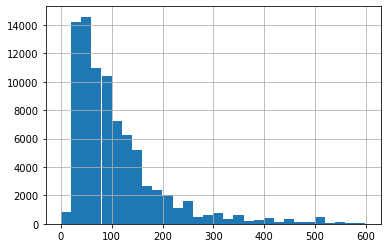

In [6]:
train["price"].hist(bins = 30)
train["price"].std()
plt.savefig('static/data/prices_stddeviation.png')


# Price by number of bedrooms:

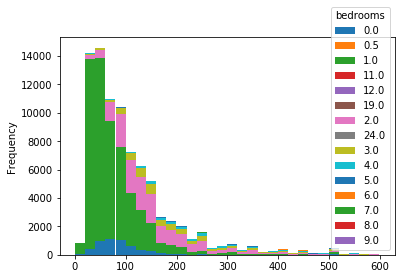

In [7]:
(train.pivot(columns = "bedrooms", values = "price")
         .plot.hist(bins = 30, stacked = True))

plt.savefig('static/data/bedrooms_price.png')

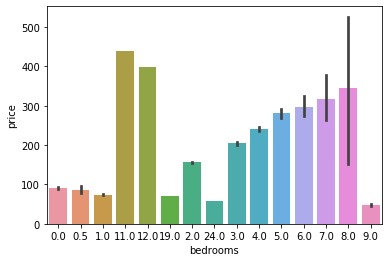

In [8]:
sns.barplot(x = "bedrooms", y = "price", data = train)
plt.savefig('static/data/price_bedrroms.png')

# Price by room_type:

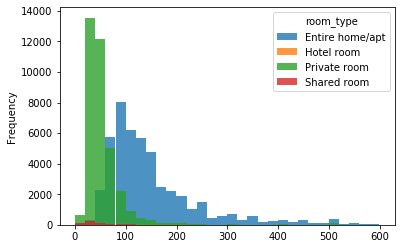

In [9]:
(train.pivot(columns = "room_type", values = "price")
         .plot.hist(bins = 30, stacked = False, alpha = 0.8))
plt.savefig('static/data/roomtype_price.png', dpi=300)


In [10]:
train.groupby("room_type")["price"].mean()

room_type
Entire home/apt    147.075432
Hotel room         143.134111
Private room        53.582948
Shared room         56.155449
Name: price, dtype: float64

Room type DOES matter - private rooms averaged around 53, entire homes averaged around 147

In [11]:
y = train["price"]
train_num_cat = train[["neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "latitude", "longitude",
                   "number_of_reviews", "require_guest_phone_verification",
                    "minimum_nights"]]

train_text = train[["name", "summary", "amenities"]]
train_text

,name,summary,amenities
0,"Studio-like floral themed bedroom, central London",A floral themed designed bedroom that A flor...,"{Wifi,Kitchen,Elevator,Heating,Washer,Dryer,Es..."
1,Our family home,A cosy private studio flat in a quiet housing ...,"{TV,Wifi,Kitchen,""Free parking on premises"",Br..."
2,Luxurious top floor flat next to Regent's Park,Beautiful and airy two bedroom flat in St. Joh...,"{TV,Wifi,Kitchen,Elevator,""Indoor fireplace"",H..."
3,Trendy East London flat with park views,Lovely house in East London Perfect if you wan...,"{TV,Wifi,Kitchen,""Free parking on premises"",""F..."
4,Spacious 2 Bedroom Flat in Great Location,"Well lit, spacious, 2 bedroom flat in West Ken...","{Wifi,Kitchen,""Paid parking off premises"",Heat..."
...,...,...,...
86353,Charing Cross Area Spacious 2BR - Covent Garden,*When sending an inquiry or placing a booking ...,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ..."
86354,1M2&3 Bricklane & Shoreditch Two Rooms,,"{Wifi,Kitchen,Heating,Washer,Essentials,Hanger..."
86355,Cozy room in a 3bed Maisonette next to Kings C...,"A welcoming beautiful house, situated in Centr...","{TV,Wifi,Kitchen,Heating,Washer,""Smoke detecto..."
86356,Luxurious Two Floored Apartment North West London,Welcome to our warm apartment which is a stone...,"{TV,""Cable TV"",Wifi,Kitchen,Heating,Washer,""Sm..."


Now let's one hot encode the categorical data:

In [12]:
X_num = pd.get_dummies(train_num_cat)

In [13]:
train_text.head()

,name,summary,amenities
0,"Studio-like floral themed bedroom, central London",A floral themed designed bedroom that A flor...,"{Wifi,Kitchen,Elevator,Heating,Washer,Dryer,Es..."
1,Our family home,A cosy private studio flat in a quiet housing ...,"{TV,Wifi,Kitchen,""Free parking on premises"",Br..."
2,Luxurious top floor flat next to Regent's Park,Beautiful and airy two bedroom flat in St. Joh...,"{TV,Wifi,Kitchen,Elevator,""Indoor fireplace"",H..."
3,Trendy East London flat with park views,Lovely house in East London Perfect if you wan...,"{TV,Wifi,Kitchen,""Free parking on premises"",""F..."
4,Spacious 2 Bedroom Flat in Great Location,"Well lit, spacious, 2 bedroom flat in West Ken...","{Wifi,Kitchen,""Paid parking off premises"",Heat..."


In [14]:
train.amenities = train.amenities.str.replace("[{}]", "")

In [15]:
amenity_ohe = train.amenities.str.get_dummies(sep = ",")

In [16]:
train.amenities = train.amenities.str.replace("[{}]", "")
amenity_ohe = train.amenities.str.get_dummies(sep = ",")

In [17]:
amenity_ohe.head(3)

,"toilet""","""24-hour check-in""","""Accessible-height bed""","""Accessible-height toilet""","""Air conditioning""","""Air purifier""","""Airport shuttle""","""Alfresco bathtub""","""Amazon Echo""","""BBQ grill""",...,Safe,Shampoo,Ski-in/Ski-out,Stove,TV,Terrace,Washer,Washer/Dryer,Waterfront,Wifi
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1


In [18]:
train["text"] = train["name"].str.cat(train["summary"], sep = " ")

In [19]:
vect = CountVectorizer(stop_words = "english", min_df = 10)

X_text = vect.fit_transform(train["text"].values.astype('U'))


In [20]:
#Models: Now build some models, first define few helper functions

In [21]:
#metric:
def rmse(y_true, y_pred):
    return(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

#evaluates rmse on a validation set:
def eval_model(model, X, y, state = 3):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, random_state = state)
    preds = model.fit(X_tr, y_tr).predict(X_val)
    return rmse(y_val, preds)

In [22]:
(X_num.shape, X_text.shape, amenity_ohe.shape)


((84514, 65), (84514, 6814), (84514, 211))

In [23]:
#this is numeric + amenities:
X = np.hstack((X_num, amenity_ohe))

#this is all of them:
X_full = np.hstack((X_num, amenity_ohe, X_text.toarray()))

In [24]:
models_rmse = [eval_model(xgb.XGBRegressor(), X_num, y),
 eval_model(xgb.XGBRegressor(), X, y),
 eval_model(Ridge(), X_num, y),
 eval_model(Ridge(), X, y)]

In [25]:
models_rmse = pd.Series(models_rmse, index = ["xgb_num", "xgb_ame", "ridge", "ridge_ame"] )
models_rmse

xgb_num      55.864955
xgb_ame      51.196783
ridge        63.831629
ridge_ame    60.589684
dtype: float64

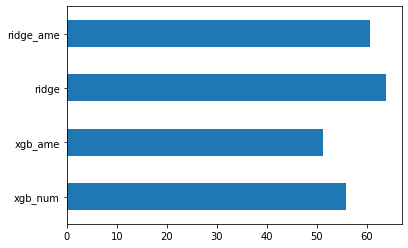

In [26]:
models_rmse.plot(kind = "barh")

# It appears xgboost is doing a little bit better than ridge and adding the amenities helps a bit ( around -1 rmse), but this is only on one validation set.

To test our different models more in depth, we will do repeated train-validation split (note this is not exactly cross validation) and then see how our errors are distributed. We also add a baseline model that always predicts the mean.

In [27]:
results = []
for i in range(30):
    X_tr, X_val, y_tr, y_val = train_test_split(X_num, y)
    y_baseline = [np.mean(y_tr)]*len(y_val)

    model = Ridge(alpha = 5)
    preds_logit = model.fit(X_tr, y_tr).predict(X_val)


    model = xgb.XGBRegressor()  
    preds_xgb = model.fit(X_tr, y_tr).predict(X_val)
    
    results.append((rmse(y_baseline, y_val),
                    rmse(preds_logit, y_val),
                    rmse(preds_xgb, y_val)
                    ))

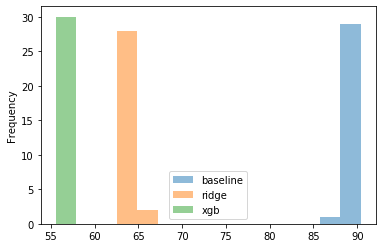

In [28]:
results = pd.DataFrame(results, columns = ["baseline", "ridge", "xgb"])
results.plot.hist(bins = 15, alpha = 0.5)

In [29]:
pd.DataFrame([results.mean(), results.std()])

,baseline,ridge,xgb
0,89.071004,63.898627,56.413411
1,0.561073,0.559170,0.498224


Clearly both ridge and xgboost beat the baseline performance by a decent margin. Also it looks like the xgboost model is performing slightly better than the Ridge Regression, good to know! If we wanted to see if the difference in rmse is statistically significant we could do a permutation test or a t-test but I'll skip that for now.